In [ ]:
pip install tensorflow-addons

In [ ]:
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import LeakyReLU
import cv2
from tqdm import tqdm
import random
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [ ]:
dataframe = pd.read_csv('age_gender.csv')
dataframe.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


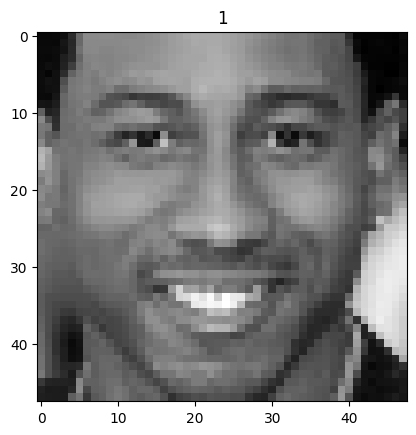

In [ ]:
index = 5005
image = np.fromstring(dataframe['pixels'][index], sep = ' ', dtype = np.uint8).reshape((48,48))
plt.title(dataframe['ethnicity'][index])
plt.imshow(image, cmap ="gray")
plt.show()

In [ ]:
EPOCHS = 70
BATCH_SIZE = 32

In [ ]:
import numpy as np
import cv2
from tqdm import tqdm
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomDataGen(Sequence):

    def __init__(self, df, batch_size=32, input_size=(48, 48, 3), shuffle=True, data_augmentation=False):
        # Filter out rows with incorrect pixel sizes
        self.df = df[df['pixels'].apply(lambda x: len(x.split()) == 48*48)]
        self.batch_size = batch_size
        self.input_size = input_size
        self.data_augmentation = data_augmentation

        self.imageGenerator = ImageDataGenerator(
            horizontal_flip=True,
            fill_mode='nearest',
            zoom_range=(1, 1.1),
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10
        )

        self.images = []
        self.age_labels = []
        self.ethnicity_labels = []
        self.gender_labels = []

        for index, row in tqdm(self.df.iterrows(), total=self.df.shape[0]):
            image = np.fromstring(row['pixels'], sep=' ', dtype=np.uint8).reshape((48, 48))
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            self.images.append(image)

            self.age_labels.append(row['age'])
            self.ethnicity_labels.append(row['ethnicity'])
            self.gender_labels.append(row['gender'])

        self.images = np.array(self.images)
        self.age_labels = np.array(self.age_labels).astype(np.float32)
        self.ethnicity_labels = np.array(self.ethnicity_labels).astype(np.float32)
        self.gender_labels = np.array(self.gender_labels).astype(np.float32)

        if shuffle:
            p = np.random.permutation(len(self.age_labels))
            self.images = self.images[p]
            self.age_labels = self.age_labels[p]
            self.ethnicity_labels = to_categorical(self.ethnicity_labels[p], num_classes=5)
            self.gender_labels = self.gender_labels[p]

        self.n = len(self.df)

    def __getitem__(self, index):
        # Calculate start and end indices for the batch
        start = index * self.batch_size
        end = min(start + self.batch_size, self.n)  # Ensure the end index is within bounds

        # Slice the data to make the batch
        images_batch = self.images[start:end]

        # Apply data augmentation if specified
        if self.data_augmentation:
            images_batch = np.array([self.imageGenerator.random_transform(img) for img in images_batch])

        # Slice the labels to make the batch
        age_labels_batch = self.age_labels[start:end]
        ethnicity_labels_batch = self.ethnicity_labels[start:end]
        gender_labels_batch = self.gender_labels[start:end]

        # Return the batch
        return images_batch, (age_labels_batch, ethnicity_labels_batch, gender_labels_batch)

    def __len__(self):
        return int(np.ceil(self.n / self.batch_size))

    def on_epoch_end(self):
        if self.data_augmentation:
            # Random permutation
            p = np.random.permutation(len(self.age_labels))
            self.images = self.images[p]
            self.age_labels = self.age_labels[p]
            self.ethnicity_labels = self.ethnicity_labels[p]
            self.gender_labels = self.gender_labels[p]

# The rest of your code for splitting the DataFrame and creating the train and validation datasets
msk = np.random.rand(len(dataframe)) < 0.8
train = dataframe[msk]
val = dataframe[~msk]

train_dataset = CustomDataGen(train, data_augmentation=True)
val_dataset = CustomDataGen(val)

100%|██████████| 4204/4204 [00:01<00:00, 2524.38it/s]


242
35.0 [0. 1. 0. 0. 0.] 1.0


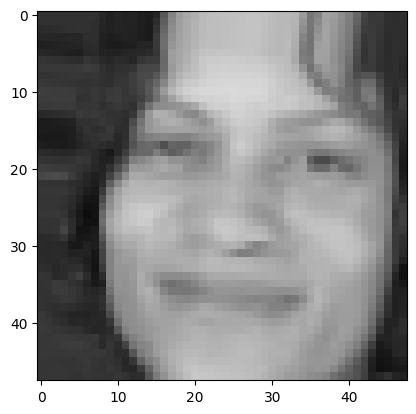

In [ ]:
train_dataset.on_epoch_end()
x, y = train_dataset[450]
print(x[21].max())
print(y[0][0], y[1][0], y[2][0])
plt.imshow(x[0])

In [ ]:
def build_model(input_shape = (48,48,3)):

    i = tf.keras.layers.Input(input_shape, dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.applications.vgg16.preprocess_input(x)

    backbone = tf.keras.applications.vgg16.VGG16(
                include_top=False, weights='imagenet',
                input_tensor=x
            )
    output_layer = backbone.get_layer("block5_conv3").output


    def build_age_branch(input_tensor):
        x = tf.keras.layers.Dense(1024, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1, activation = None, name = 'age_output')(x)

        return x

    def build_etchnicity_branch(input_tensor):
        x = tf.keras.layers.Dense(500, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(5, activation = 'softmax', name = 'ethnicity_output')(x)

        return x

    def build_gender_branch(input_tensor):
        x = tf.keras.layers.Dense(500, activation = LeakyReLU(alpha=0.3))(input_tensor)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'gender_output')(x)

        return x

    x = tf.keras.layers.Flatten()(output_layer)
    output_age = build_age_branch(x)
    output_ethnicity = build_etchnicity_branch(x)
    output_gender = build_gender_branch(x)
    model = tf.keras.Model(i, [output_age, output_ethnicity, output_gender])

    return model

In [ ]:
model = build_model()
model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 tf.cast (TFOpLambda)        (None, 48, 48, 3)            0         ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.getitem (  (None, 48, 48, 3)            0         ['tf.cast[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.nn.bias_add (TFOpLambda  

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss = ['mse', 'categorical_crossentropy', 'binary_crossentropy'], loss_weights = [0.001,0.5,0.5],
              metrics = {'age_output': 'mean_absolute_error', 'ethnicity_output': 'accuracy', 'gender_output': 'accuracy'})

plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose = 1)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5)
save_best = tf.keras.callbacks.ModelCheckpoint('weights_v1.h5', monitor='val_loss', save_best_only=True,mode='min', save_weights_only = True)

history = model.fit(train_dataset,
            epochs=EPOCHS,
            batch_size = BATCH_SIZE,
            validation_data=val_dataset,
            callbacks = [es, save_best, plateau])

Epoch 1/70
520/520 [==============================] - 54s 67ms/step - loss: 1.6793 - age_output_loss: 931.1150 - ethnicity_output_loss: 1.0836 - gender_output_loss: 0.4128 - age_output_mean_absolute_error: 28.3723 - ethnicity_output_accuracy: 0.6252 - gender_output_accuracy: 0.8186 - val_loss: 1.2535 - val_age_output_loss: 692.6421 - val_ethnicity_output_loss: 0.8221 - val_gender_output_loss: 0.2996 - val_age_output_mean_absolute_error: 24.1800 - val_ethnicity_output_accuracy: 0.7131 - val_gender_output_accuracy: 0.8673 - lr: 1.0000e-04
Epoch 2/70
520/520 [==============================] - 38s 74ms/step - loss: 1.2447 - age_output_loss: 675.6149 - ethnicity_output_loss: 0.8334 - gender_output_loss: 0.3048 - age_output_mean_absolute_error: 24.0929 - ethnicity_output_accuracy: 0.7139 - gender_output_accuracy: 0.8718 - val_loss: 1.2352 - val_age_output_loss: 606.7484 - val_ethnicity_output_loss: 0.9624 - val_gender_output_loss: 0.2946 - val_age_output_mean_absolute_error: 22.3251 - val_et

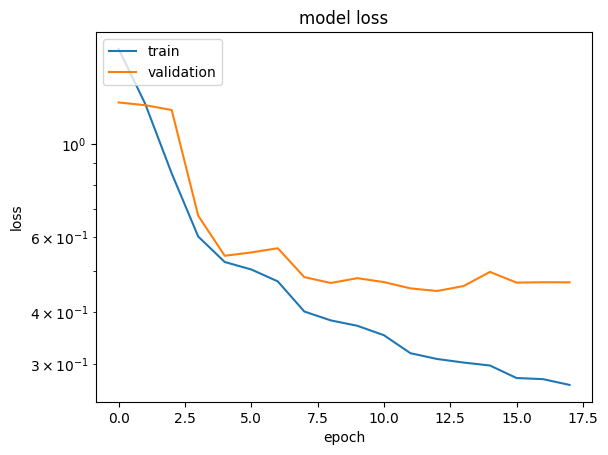

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.yscale('log')
plt.show()

In [ ]:
model.load_weights('weights_v1.h5')
model.evaluate(val_dataset)

132/132 [==============================] - 3s 19ms/step - loss: 0.4479 - age_output_loss: 57.9267 - ethnicity_output_loss: 0.5782 - gender_output_loss: 0.2018 - age_output_mean_absolute_error: 5.5787 - ethnicity_output_accuracy: 0.8185 - gender_output_accuracy: 0.9272


[0.44791436195373535,
 57.92669677734375,
 0.578220546245575,
 0.2017551064491272,
 5.5787458419799805,
 0.8185061812400818,
 0.9272121787071228]

In [ ]:
names_ethnicity = ['white', 'black', 'asian', 'indian', 'other']
name_genders = ['male', 'female']

1/1 [==============================] - 0s 38ms/step


<ipython-input-34-9517158a4086>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'Prediction: {int(p[0][index])} years, {names_ethnicity[p[1][index].argmax()]}, {name_genders[gender_predictions[index][0]]}\n'+


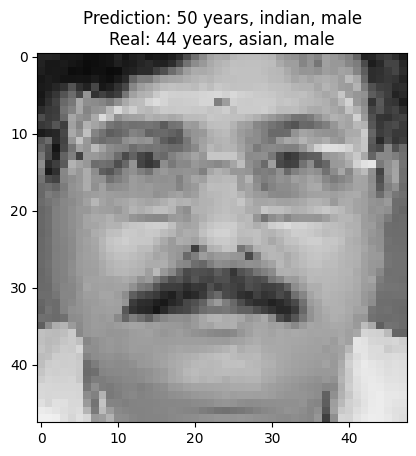

In [ ]:
images, labels = val_dataset[76]
index = 0

p = model.predict(images)

gender_predictions = tf.where(p[2] > 0.5, 1, 0)
plt.title(f'Prediction: {int(p[0][index])} years, {names_ethnicity[p[1][index].argmax()]}, {name_genders[gender_predictions[index][0]]}\n'+
         f'Real: {int(labels[0][index])} years, {names_ethnicity[labels[1][index].argmax()]}, {name_genders[int(labels[2][index])]}')
plt.imshow(images[index])
plt.show()